#EfficientNet B0

In [ ]:
# 📦 Imports
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import accuracy_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "/content/drive/MyDrive/Brain MRI/Training"
test_dir = "/content/drive/MyDrive/Brain MRI/Testing"


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# 🧠 Load Pretrained EfficientNetB0
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# 🔧 Modify Classifier (with Dropout)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 4)
)

# 🔓 Fine-tune last 20 layers
for param in model.features[-20:].parameters():
    param.requires_grad = True

model = model.to(device)


In [ ]:
# 🧪 Loss & Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from torchsummary import summary

# For EfficientNetB0 (input: 3x224x224 RGB image)
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
# 🔁 Training
epochs = 15
train_loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    scheduler.step(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")



Epoch 1/15: 100%|██████████| 180/180 [01:07<00:00,  2.67it/s]


Epoch 1, Loss: 0.6481


Epoch 2/15: 100%|██████████| 180/180 [01:08<00:00,  2.63it/s]


Epoch 2, Loss: 0.4460


Epoch 3/15: 100%|██████████| 180/180 [01:07<00:00,  2.69it/s]


Epoch 3, Loss: 0.4154


Epoch 4/15: 100%|██████████| 180/180 [01:06<00:00,  2.70it/s]


Epoch 4, Loss: 0.3963


Epoch 5/15: 100%|██████████| 180/180 [01:06<00:00,  2.70it/s]


Epoch 5, Loss: 0.3855


Epoch 6/15: 100%|██████████| 180/180 [01:06<00:00,  2.69it/s]


Epoch 6, Loss: 0.3791


Epoch 7/15: 100%|██████████| 180/180 [01:07<00:00,  2.67it/s]


Epoch 7, Loss: 0.3757


Epoch 8/15: 100%|██████████| 180/180 [01:07<00:00,  2.68it/s]


Epoch 8, Loss: 0.3715


Epoch 9/15: 100%|██████████| 180/180 [01:06<00:00,  2.69it/s]


Epoch 9, Loss: 0.3676


Epoch 10/15: 100%|██████████| 180/180 [01:06<00:00,  2.69it/s]


Epoch 10, Loss: 0.3645


Epoch 11/15: 100%|██████████| 180/180 [01:07<00:00,  2.69it/s]


Epoch 11, Loss: 0.3644


Epoch 12/15: 100%|██████████| 180/180 [01:06<00:00,  2.69it/s]


Epoch 12, Loss: 0.3621


Epoch 13/15: 100%|██████████| 180/180 [01:07<00:00,  2.68it/s]


Epoch 13, Loss: 0.3640


Epoch 14/15: 100%|██████████| 180/180 [01:07<00:00,  2.66it/s]


Epoch 14, Loss: 0.3634


Epoch 15/15: 100%|██████████| 180/180 [01:07<00:00,  2.68it/s]

Epoch 15, Loss: 0.3595


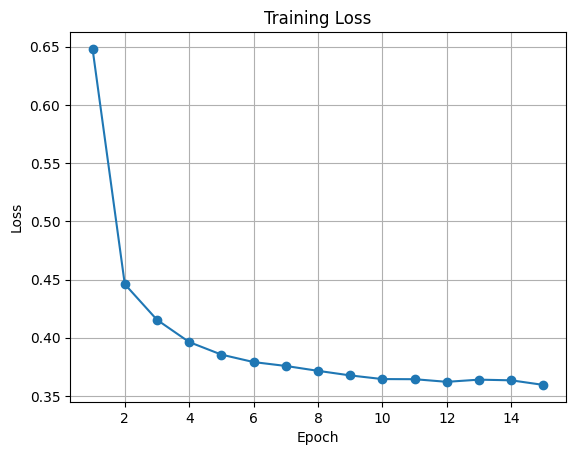

In [ ]:
# 📉 Loss Plot
plt.plot(range(1, epochs+1), train_loss, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# 📈 Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

acc = accuracy_score(y_true, y_pred)
print(f"\n🎯 Test Accuracy: {acc * 100:.2f}%")
print("\n📄 Classification Report:\n", classification_report(y_true, y_pred, target_names=test_data.classes))



🎯 Test Accuracy: 99.31%

📄 Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.98      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



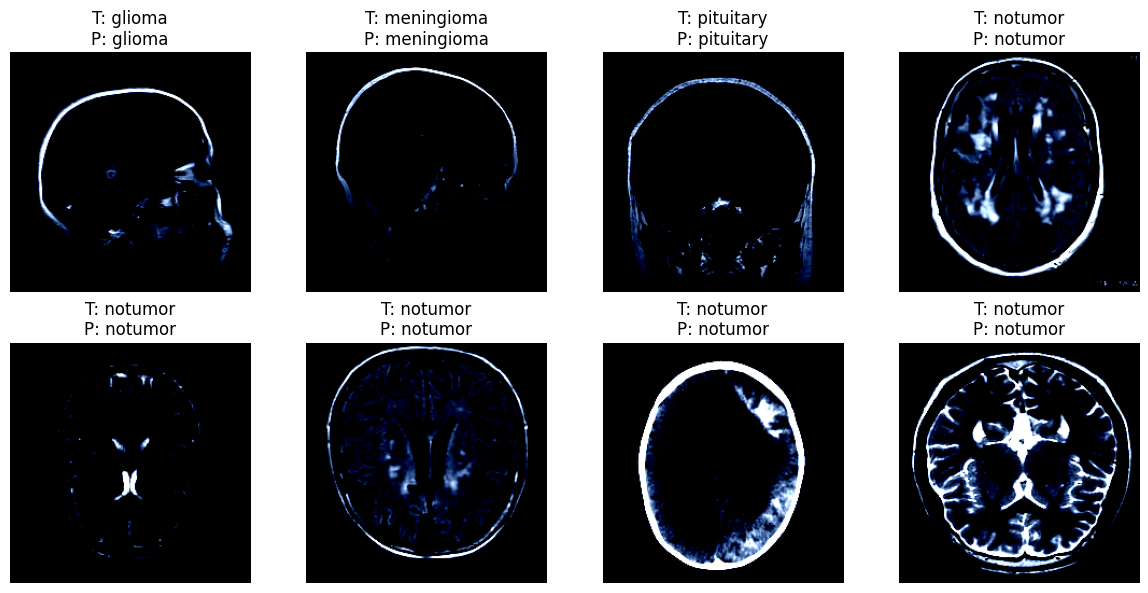

In [ ]:
import random
import matplotlib.pyplot as plt

# 📂 Class names
classes = test_data.classes

# 🎯 Random indices
indices = random.sample(range(len(test_data)), 8)

# 🔍 Prediction loop
model.eval()
plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    image, true_label = test_data[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    plt.subplot(2, 4, i + 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(f"T: {classes[true_label]}\nP: {classes[pred]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


import random
import matplotlib.pyplot as plt
import torch

# ⚙️ Normalization stats (used during transform)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# 📂 Class names
classes = test_data.classes

# 🎯 Pick 8 random test samples
indices = random.sample(range(len(test_data)), 8)

# # 🔍 Prediction + Plot
# model.eval()
# plt.figure(figsize=(14, 7))

# for i, idx in enumerate(indices):
#     image, true_label = test_data[idx]
#     input_tensor = image.unsqueeze(0).to(device)

#     with torch.no_grad():
#         output = model(input_tensor)
#         pred = torch.argmax(output, dim=1).item()

#     # ✅ De-normalize image for correct display
#     image_disp = image * std[:, None, None] + mean[:, None, None]
#     image_disp = image_disp.clamp(0, 1)

#     plt.subplot(2, 4, i + 1)
#     plt.imshow(image_disp.permute(1, 2, 0).cpu().numpy())
#     title_color = "green" if pred == true_label else "red"
#     plt.title(f"T: {classes[true_label]}\nP: {classes[pred]}", color=title_color)
#     plt.axis("off")

# plt.suptitle("🧠 MRI Tumor Detection — Actual vs Predicted", fontsize=16)
# plt.tight_layout()
# plt.show()



In [ ]:
model_path = "/content/efficientnet_b0_brain_mri.pth"
torch.save(model.state_dict(), model_path)


In [ ]:
import zipfile

zip_path = "/content/efficientnet_model.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(model_path)


In [ ]:
from google.colab import files
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#New VGG16

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# ✅ Data transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
# ✅ Dataset paths
train_dir = '/content/drive/MyDrive/Brain MRI/Training'
test_dir = '/content/drive/MyDrive/Brain MRI/Testing'

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from tqdm import tqdm

In [12]:
# 🧠 Load Pretrained VGG16
model = models.vgg16(pretrained=True)

# ❄️ Freeze base layers
for param in model.features.parameters():
    param.requires_grad = False

# 🔧 Modify classifier (added dropout)
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(4096, 4)
)
model = model.to(device)

In [14]:
# 🧪 Loss (label smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ⚙️ Optimizer + Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
# 📦 Update DataLoaders
# 📦 Update DataLoaders (corrected variable names)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)



In [17]:
# 🔁 Training Loop
epochs = 10
train_loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"🔁 Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    scheduler.step(epoch_loss)

    print(f"✅ Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

🔁 Epoch 1/10: 100%|██████████| 180/180 [13:03<00:00,  4.35s/it]


✅ Epoch 1/10 - Loss: 0.7129


🔁 Epoch 2/10: 100%|██████████| 180/180 [01:06<00:00,  2.70it/s]


✅ Epoch 2/10 - Loss: 0.5765


🔁 Epoch 3/10: 100%|██████████| 180/180 [01:07<00:00,  2.67it/s]


✅ Epoch 3/10 - Loss: 0.5285


🔁 Epoch 4/10: 100%|██████████| 180/180 [01:14<00:00,  2.42it/s]


✅ Epoch 4/10 - Loss: 0.5151


🔁 Epoch 5/10: 100%|██████████| 180/180 [01:11<00:00,  2.50it/s]


✅ Epoch 5/10 - Loss: 0.4910


🔁 Epoch 6/10: 100%|██████████| 180/180 [01:08<00:00,  2.64it/s]


✅ Epoch 6/10 - Loss: 0.4639


🔁 Epoch 7/10: 100%|██████████| 180/180 [01:09<00:00,  2.59it/s]


✅ Epoch 7/10 - Loss: 0.4501


🔁 Epoch 8/10: 100%|██████████| 180/180 [01:05<00:00,  2.77it/s]


✅ Epoch 8/10 - Loss: 0.4428


🔁 Epoch 9/10: 100%|██████████| 180/180 [01:13<00:00,  2.44it/s]


✅ Epoch 9/10 - Loss: 0.4381


🔁 Epoch 10/10: 100%|██████████| 180/180 [01:05<00:00,  2.73it/s]

✅ Epoch 10/10 - Loss: 0.4277


In [20]:
# 🔓 Unfreeze all layers
for param in model.features.parameters():
    param.requires_grad = True

# 🔁 New optimizer with lower LR
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 5
fine_tune_loss = []

for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"🔧 Fine-tune Epoch {epoch+1}/{fine_tune_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    fine_tune_loss.append(epoch_loss)
    print(f"✅ Fine-tune Epoch {epoch+1} - Loss: {epoch_loss:.4f}")


🔧 Fine-tune Epoch 1/5: 100%|██████████| 180/180 [01:32<00:00,  1.95it/s]


✅ Fine-tune Epoch 1 - Loss: 0.4137


🔧 Fine-tune Epoch 2/5: 100%|██████████| 180/180 [01:31<00:00,  1.96it/s]


✅ Fine-tune Epoch 2 - Loss: 0.4032


🔧 Fine-tune Epoch 3/5: 100%|██████████| 180/180 [01:32<00:00,  1.94it/s]


✅ Fine-tune Epoch 3 - Loss: 0.3945


🔧 Fine-tune Epoch 4/5: 100%|██████████| 180/180 [01:31<00:00,  1.97it/s]


✅ Fine-tune Epoch 4 - Loss: 0.3893


🔧 Fine-tune Epoch 5/5: 100%|██████████| 180/180 [01:31<00:00,  1.96it/s]

✅ Fine-tune Epoch 5 - Loss: 0.3851


In [22]:
# 🔍 Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 🎯 Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")


✅ Test Accuracy: 98.09%


In [23]:
print("\n📄 Classification Report:\n", classification_report(y_true, y_pred, target_names=test_dataset.classes))



📄 Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       300
  meningioma       0.96      0.96      0.96       306
     notumor       0.99      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



/tmp/ipython-input-24-1958592937.py:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


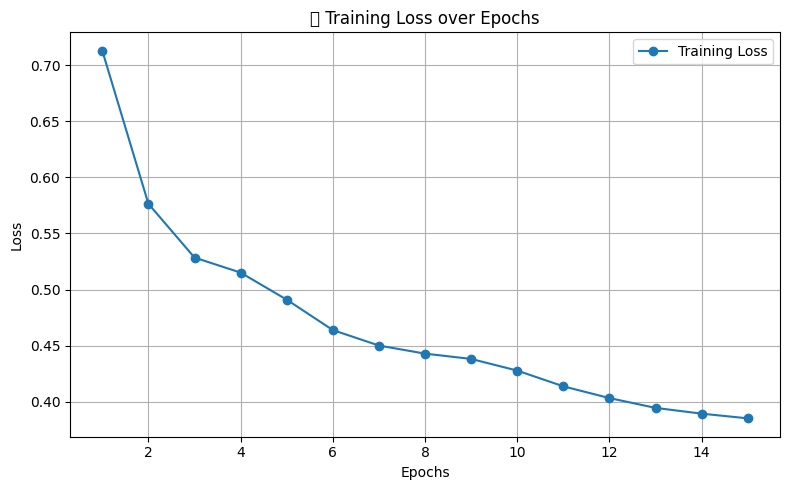

In [24]:
import matplotlib.pyplot as plt

# 📉 Combine losses if you trained in two phases
all_loss = train_loss + fine_tune_loss

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_loss)+1), all_loss, marker='o', label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("📉 Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-36-3891182588.py:35: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


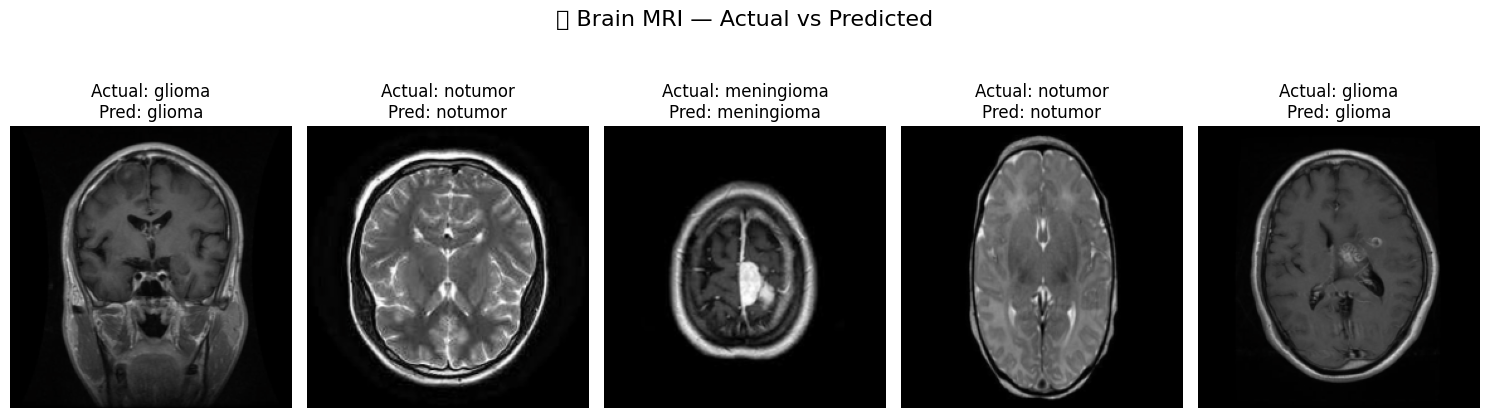

In [36]:
import random
import matplotlib.pyplot as plt
import torch

# ⛔ Normalization params used in your transforms
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# 🔍 Evaluate mode
model.eval()

# 🔀 Pick 5 random test samples
indices = random.sample(range(len(test_dataset)), 5)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    image, true_label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    # ✅ De-normalize the image for display
    denorm = image * std[:, None, None] + mean[:, None, None]
    denorm = denorm.clamp(0, 1)

    plt.subplot(1, 5, i+1)
    plt.imshow(denorm.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Actual: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[pred_label]}")
    plt.axis('off')

plt.suptitle("🧠 Brain MRI — Actual vs Predicted", fontsize=16)
plt.tight_layout()
plt.show()


In [35]:
# 🔽 1. Save model weights
torch.save(model.state_dict(), "vgg16_brain_mri.pth")

# 📦 2. Zip the file
import zipfile

with zipfile.ZipFile("vgg16_brain_mri.zip", "w") as zipf:
    zipf.write("vgg16_brain_mri.pth")


In [37]:
# ⬇️ 3. Trigger download
from google.colab import files
files.download("vgg16_brain_mri.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#ResNet50

In [38]:
# 📦 Imports
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
from tqdm import tqdm

In [39]:
# 📍 Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# 📁 Paths
train_dir = "/content/drive/MyDrive/Brain MRI/Training"
test_dir = "/content/drive/MyDrive/Brain MRI/Testing"

# 🧼 Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


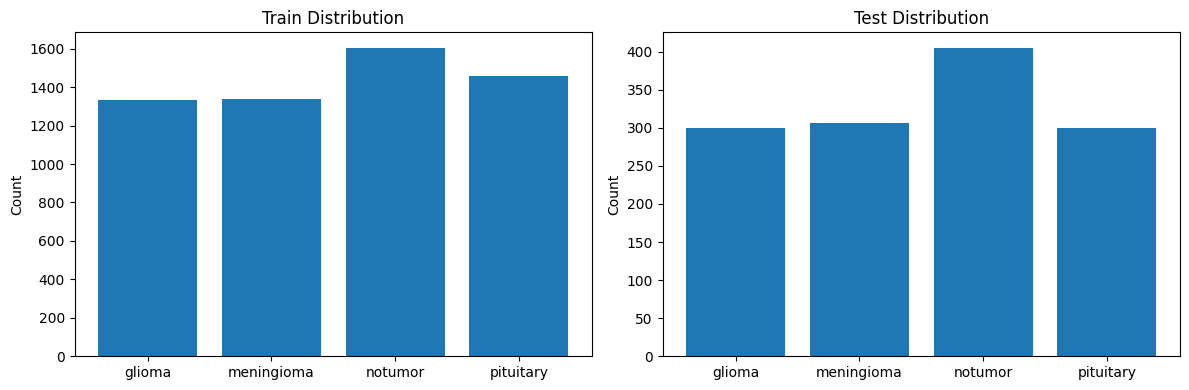

In [41]:
# 🔄 Load
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# 📊 Class distribution
def plot_class_dist(dataset, title, subplot, label_names):
    labels = [label for _, label in dataset.samples]
    counts = Counter(labels)
    subplot.bar([label_names[i] for i in counts.keys()], counts.values())
    subplot.set_title(title)
    subplot.set_ylabel("Count")

# 🔍 Class names
class_names = train_data.classes

# 📈 Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_class_dist(train_data, "Train Distribution", ax[0], class_names)
plot_class_dist(test_data, "Test Distribution", ax[1], class_names)
plt.tight_layout()
plt.show()


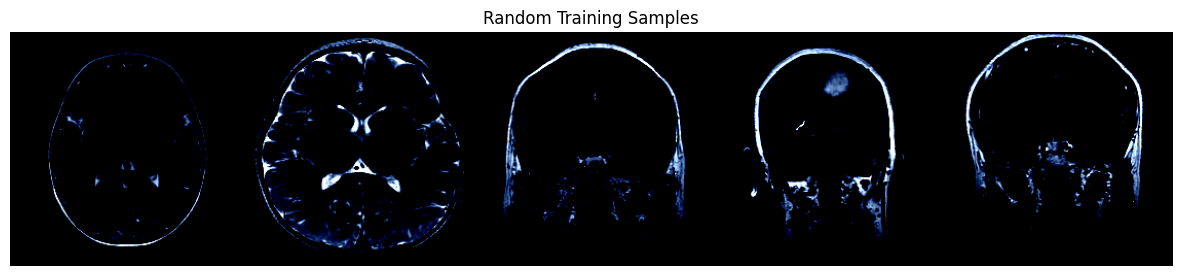

Labels: ['notumor', 'notumor', 'pituitary', 'meningioma', 'pituitary']


In [42]:
# 🖼️ Visualize random 5 images from train set
def show_random_images(dataset, class_names):
    loader = DataLoader(dataset, batch_size=5, shuffle=True)
    images, labels = next(iter(loader))
    img_grid = make_grid(images, nrow=5)
    plt.figure(figsize=(15, 5))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.title('Random Training Samples')
    plt.axis('off')
    plt.show()
    print("Labels:", [class_names[i] for i in labels])

show_random_images(train_data, class_names)


In [43]:
# 🧠 Load pretrained ResNet-50
model = models.resnet50(pretrained=True)

# ✅ Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# 🔓 Unfreeze last 10 layers (to reduce fine-tune time)
for param in list(model.parameters())[-10*2:]:  # *2: weight + bias
    param.requires_grad = True

# 🧪 Modify classifier
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 4)  # 4 classes
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


In [44]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [45]:
epochs = 10
train_loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    scheduler.step(epoch_loss)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1/10: 100%|██████████| 180/180 [01:14<00:00,  2.42it/s]


Epoch 1, Loss: 0.5786


Epoch 2/10: 100%|██████████| 180/180 [01:02<00:00,  2.87it/s]


Epoch 2, Loss: 0.4370


Epoch 3/10: 100%|██████████| 180/180 [01:03<00:00,  2.85it/s]


Epoch 3, Loss: 0.4102


Epoch 4/10: 100%|██████████| 180/180 [01:02<00:00,  2.88it/s]


Epoch 4, Loss: 0.3935


Epoch 5/10: 100%|██████████| 180/180 [01:01<00:00,  2.92it/s]


Epoch 5, Loss: 0.3819


Epoch 6/10: 100%|██████████| 180/180 [01:02<00:00,  2.90it/s]


Epoch 6, Loss: 0.3818


Epoch 7/10: 100%|██████████| 180/180 [01:02<00:00,  2.88it/s]


Epoch 7, Loss: 0.3754


Epoch 8/10: 100%|██████████| 180/180 [01:03<00:00,  2.83it/s]


Epoch 8, Loss: 0.3699


Epoch 9/10: 100%|██████████| 180/180 [01:02<00:00,  2.89it/s]


Epoch 9, Loss: 0.3694


Epoch 10/10: 100%|██████████| 180/180 [01:02<00:00,  2.90it/s]

Epoch 10, Loss: 0.3705


In [47]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ✅ Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n🎯 Test Accuracy: {acc * 100:.2f}%")



🎯 Test Accuracy: 99.24%


In [48]:
# 📄 Detailed Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_data.classes))


📋 Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.97      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



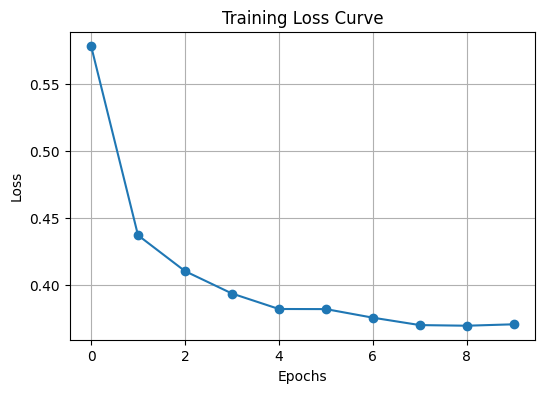

In [49]:
# Plot loss curve
plt.figure(figsize=(6, 4))
plt.plot(train_loss, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


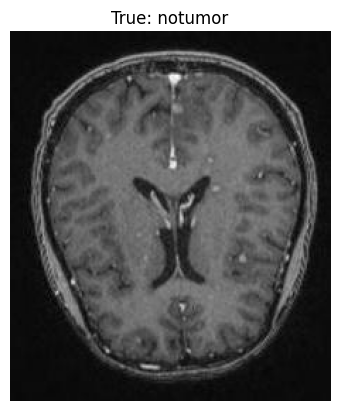

🔍 Predicted: notumor


In [62]:
import random
from PIL import Image

def predict_random_image():
    random_idx = random.randint(0, len(test_data) - 1)
    img_path, true_label = test_data.samples[random_idx]
    img = Image.open(img_path).convert("RGB")

    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Transform and predict
    input_tensor = test_transforms(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    print(f"🔍 Predicted: {class_names[pred.item()]}")

predict_random_image()


/tmp/ipython-input-63-2215736159.py:37: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


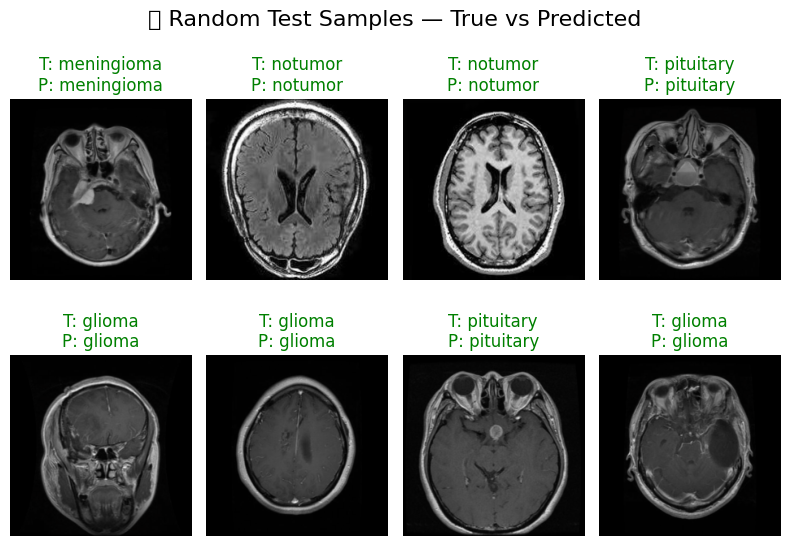

In [63]:
import random
import matplotlib.pyplot as plt

# 🔁 Denormalization values (used during transforms)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# 📂 Class labels
classes = test_data.classes

# 🎯 Pick 8 random test samples
indices = random.sample(range(len(test_data)), 8)

# 🧠 Set model to eval mode
model.eval()
plt.figure(figsize=(8, 6))

for i, idx in enumerate(indices):
    image, true_label = test_data[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    # ✅ De-normalize for visualization
    image_disp = image * std[:, None, None] + mean[:, None, None]
    image_disp = image_disp.clamp(0, 1)

    plt.subplot(2, 4, i + 1)
    plt.imshow(image_disp.permute(1, 2, 0).cpu().numpy())
    color = "green" if pred == true_label else "red"
    plt.title(f"T: {classes[true_label]}\nP: {classes[pred]}", color=color)
    plt.axis("off")

plt.suptitle("🔍 Random Test Samples — True vs Predicted", fontsize=16)
plt.tight_layout()
plt.show()


In [59]:
# Save the trained model
model_path = "/content/resnet50_brain_mri.pth"
torch.save(model.state_dict(), model_path)


In [60]:
import zipfile

# Create a zip file
zip_path = "/content/resnet50_brain_mri.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(model_path, arcname="resnet50_brain_mri.pth")


In [61]:
from google.colab import files

# Download zip file
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>